In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# %%
import os
import math
import numpy as np
import torch
import torch.nn as nn
from drive.MyDrive.ATNLP.crispy_fortnight.transformer import Transformer
import pandas as pd
from torch.utils.data import DataLoader, Dataset
from torch.nn.utils.rnn import pad_sequence
import torch.optim as optim
from tqdm import tqdm
import wandb

# %%
# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device('mps')

# EXPERIMENT 2:
EMB_DIM = 128
N_LAYERS = 2
N_HEADS = 8
FORWARD_DIM = 256
DROPOUT = 0.15
LEARNING_RATE = 2e-4
GRAD_CLIP = 1
BATCH_SIZE = 16
MAX_LEN = 128

In [3]:
print(f"On {device}")

On cuda


In [4]:
# Task 0: DataLoader and Preprocessing
class TasksData(Dataset):
    def __init__(self, data_dir, file, transform=None):
        self.data_dir = data_dir
        self.file = file
        text_file = os.path.join(data_dir, file)

        data_dict = {"src": [], "tgt": []}

        with open(text_file, 'r') as f:
            lines = f.readlines()
            for line in lines:
                src = line.split('OUT:')[0]
                src = src.split('IN:')[1].strip()
                tgt = line.split('OUT:')[1].strip()

                data_dict['src'].append(src)
                data_dict['tgt'].append(tgt)

        self.data = pd.DataFrame(data_dict)


    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        src = self.data['src'].iloc[idx] + ' <EOS>'
        tgt = '<SOS> ' + self.data['tgt'].iloc[idx] + ' <EOS>'
        return src, tgt

def create_vocab(dataset):
    vocab = set()

    for sample in dataset:
        vocab.update(sample.split())
    return vocab

# %%
# creating datasets
train_data = TasksData(data_dir='/content/drive/MyDrive/ATNLP/crispy_fortnight/data/experiment2', file='tasks_train_length.txt')
test_data = TasksData(data_dir='/content/drive/MyDrive/ATNLP/crispy_fortnight/data/experiment2', file='tasks_test_length.txt')

#creating source and target vocab
src_train_data = [src for src, tgt in train_data]
vocab_train_src = create_vocab(src_train_data)

tgt_train_data = [tgt for src, tgt in train_data]
vocab_train_tgt = create_vocab(tgt_train_data)

# we need to do word2idx to map the words to indexes. Bc the input for nn.Embedding has to be numbers
# since nn.Embdding has different weights in input andoutput embedding the same index will not be encoded to the same vector
word2idx_src = {w: idx + 1 for (idx, w) in enumerate(vocab_train_src)}
word2idx_src['<PAD>'] = 0

word2idx_tgt= {w: idx + 1 for (idx, w) in enumerate(vocab_train_tgt)}
word2idx_tgt['<PAD>'] = 0

def custom_collate_fn(batch):
    #input: batch of sentences
    # tokenize, word2idx, pad
    padded_src = pad_sequence([torch.tensor([word2idx_src[w] for w in src.split()]) for src, tgt in batch], batch_first=True, padding_value=0).to(device)
    padded_tgt = pad_sequence([torch.tensor([word2idx_tgt[w] for w in tgt.split()]) for src, tgt in batch], batch_first=True, padding_value=0).to(device)

    return padded_src, padded_tgt

# %%
# create dataloaders
train_loader = DataLoader(train_data, batch_size=BATCH_SIZE, shuffle=True, collate_fn=custom_collate_fn)
test_loader = DataLoader(test_data, batch_size=BATCH_SIZE, shuffle=False, collate_fn=custom_collate_fn)

In [5]:
# define the model
model = Transformer(
    src_vocab_size=len(word2idx_src),
    tgt_vocab_size=len(word2idx_tgt),
    src_pad_idx=word2idx_src['<PAD>'],
    tgt_pad_idx=word2idx_tgt['<PAD>'],
    emb_dim=EMB_DIM,
    num_layers=N_LAYERS,
    num_heads=N_HEADS,
    forward_dim=FORWARD_DIM,
    dropout=DROPOUT,
    max_len=MAX_LEN,
).to(device)

## ACCURACY FUNCTIONS

In [6]:
def token_lvl_accuracy(gt, pred):
    """
    gt = ground truth sequence
    pred = predicted sequence
    """
    correct = 0

    # get start and end
    eos_idx = word2idx_tgt['<EOS>']
    sos_idx = word2idx_tgt['<SOS>']
    # print(eos_idx)
    # print(sos_idx)
    pred = pred[-1]


    gt = gt[-1]

    # index of <SOS> and <EOS> tokens of the predicted sequence
    pred_start = 0
    pred_end = len(pred) if (eos_idx not in pred) else (pred == eos_idx).nonzero(as_tuple=True)[0].item()

    # index of <SOS> and <EOS> tokens of the ground truth sequence
    gt_start = (gt == sos_idx).nonzero(as_tuple=True)[0].item()
    gt_end = (gt == eos_idx).nonzero(as_tuple=True)[0].item()

    # slicing
    gt = gt[gt_start+1 : gt_end]
    pred = pred[pred_start+1 : pred_end]

    longer = gt if len(gt) > len(pred) else pred
    shorter = pred if len(gt) > len(pred) else gt

    longest_len = len(longer)

    shorter = torch.nn.functional.pad(shorter, (0, longest_len - len(shorter)), "constant", 0)

    correct = sum(longer == shorter)
    # print(longer)
    # print(shorter)
    # print(correct)
    return int(correct) / len(shorter) # same length as longer


def sequence_level_accuracy(gt, pred):

    # get start and end
    eos_idx = word2idx_tgt['<EOS>']
    sos_idx = word2idx_tgt['<SOS>']
    # print(eos_idx)
    # print(sos_idx)
    pred = pred[-1]
    gt = gt[-1]

    # index of <SOS> and <EOS> tokens of the predicted sequence
    pred_start = 0
    pred_end = len(pred) if (eos_idx not in pred) else (pred == eos_idx).nonzero(as_tuple=True)[0].item()

    # index of <SOS> and <EOS> tokens of the ground truth sequence
    gt_start = (gt == sos_idx).nonzero(as_tuple=True)[0].item()
    gt_end = (gt == eos_idx).nonzero(as_tuple=True)[0].item()

    # slicing
    gt = gt[gt_start+1 : gt_end]
    pred = pred[pred_start+1 : pred_end]

    if len(gt) != len(pred):
        return 0

    if sum(gt == pred) == len(gt):
        return 1

    return 0


## TRAINING

In [17]:
optimizer = optim.AdamW(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index=word2idx_tgt['<PAD>'])

# Training loop
num_epochs = 75  # Updated to 75 epochs
checkpoint_interval = 25  # Save checkpoint every 25 epochs
losses = []

# Initialize wandb
wandb.init(project="transformer_training", name=f"experiment_2_{num_epochs}_epochs")  # Use appropriate project and run names
wandb.config = {
    "learning_rate": LEARNING_RATE,
    "epochs": num_epochs,
    "batch_size": train_loader.batch_size,
    "gradient_clip": GRAD_CLIP
}

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for step, (src, tgt) in (pbar := tqdm(enumerate(train_loader), total=len(train_loader))):
        src, tgt = src.to(device), tgt.to(device)

        optimizer.zero_grad()

        # output = model(src, tgt)
        output = model(src, tgt[:, :-1])
        output_dim = output.shape[-1]

        output = output.contiguous().view(-1, output_dim)
        tgt = tgt[:, 1:].contiguous().view(-1)

        loss = criterion(output, tgt)
        loss.backward()

        # Gradient clipping
        torch.nn.utils.clip_grad_norm_(model.parameters(), GRAD_CLIP)

        wandb.log({"Step Loss": loss.item()})
        pbar.set_description(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss:.4f}')

        optimizer.step()
        epoch_loss += loss.item()

    avg_epoch_loss = epoch_loss / len(train_loader)
    losses.append(avg_epoch_loss)

    # Log average epoch loss to wandb
    wandb.log({"Epoch Loss": avg_epoch_loss})

    # Save checkpoint every 'checkpoint_interval' epochs
    if (epoch + 1) % checkpoint_interval == 0 or (epoch + 1) == num_epochs:
        checkpoint_path = f"/content/drive/MyDrive/ATNLP/crispy_fortnight/17_12_2024_transformer_exp2_epoch_{epoch+1}.pth"
        torch.save({
            'epoch': epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'losses': losses,  # Save losses up to the current epoch
        }, checkpoint_path)
        print(f"Checkpoint saved at: {checkpoint_path}")

wandb.finish()


Epoch [25/25], Loss: 0.0001: 100%|██████████| 1062/1062 [00:21<00:00, 48.51it/s]


Epoch Loss,▅▇▄▄▂▅▄▂█▁▃▃▃▃▆▂▇▄▂▁▅▅▅▃▂
Step Loss,▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▃▁▁▃▂
Epoch Loss,0.00146
Step Loss,8e-05


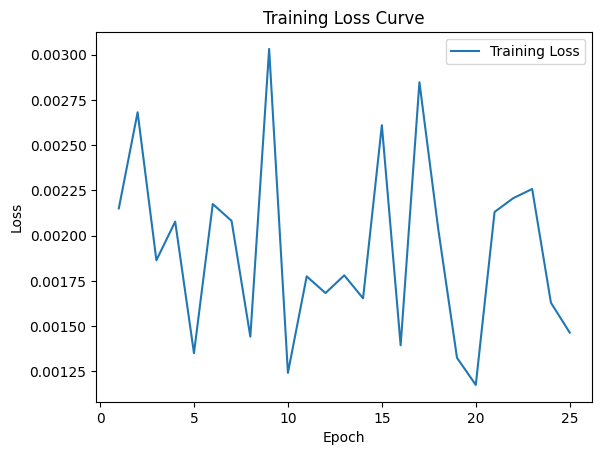

In [22]:
import matplotlib.pyplot as plt
# plt.figure(1)
# plt.plot(losses)

wandb.init(project="transformer_training", name=f"experiment_2_{num_epochs}_epochs_plot")  # Use appropriate project and run names

# Plot and log the loss curve
plt.plot(range(1, len(losses) + 1), losses, label="Training Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.legend()
plt.savefig("loss_curve.png")  # Save the plot locally

# Log the plot to wandb
wandb.log({"Loss Curve": wandb.Image("loss_curve.png")})


In [23]:
# Reverse the word-to-index mapping
idx2word_src = {idx: w for w, idx in word2idx_src.items()}
idx2word_tgt = {idx: w for w, idx in word2idx_tgt.items()}

def decode_indices(indices, idx2word):
    return ' '.join(idx2word[idx] for idx in indices if idx in idx2word and idx != word2idx_src['<PAD>'])

In [24]:
print(word2idx_tgt['<SOS>'])
print(word2idx_tgt['<EOS>'])

6
4


In [25]:
# EXPLANATION: I had to make length functions thta return the length of the sequence without the special tokens to get the keys for the dictionaries
# One of them uses the word2idx_src and the other uses the word2idx_tgt to remove the special tokens and return the length

def length_tgt(seq):
    pad_token = word2idx_tgt['<PAD>']
    sos_token = word2idx_tgt['<SOS>']
    eos_token = word2idx_tgt['<EOS>']

    # seq is a tensor of numbers clean it form all pad, sos, or eos tokens
    seq = seq[seq != pad_token]
    seq = seq[seq != sos_token]
    seq = seq[seq != eos_token]

    return len(seq)


def length_src(seq):
    pad_token = word2idx_src['<PAD>']
    eos_token = word2idx_src['<EOS>']

    # seq is a tensor of numbers clean it form all pad, sos, or eos tokens
    seq = seq[seq != pad_token]
    seq = seq[seq != eos_token]

    return len(seq)


# decoded_sentences = [idx2word_src[w] for w in [ 6,  5, 11, 14,  8,  0,  0,  0,  0,  0]]
# print(decoded_sentences)

# print(length_src(torch.tensor([ 6,  5, 11, 14,  8,  0,  0,  0,  0,  0])))

# Without oracle

In [26]:
#EXPLANATION: This is the same as when you have last seen it I only changed the calculation of the lengths of the sequences to use as keys
#checkpoint_path = "transformer_exp2_test.pth"


# Initialize wandb for testing
wandb.init(project="transformer_testing", name="test_results_17_12_2024_transformer_exp2_{num_epochs}")

# Load model checkpoint
ckp = torch.load(checkpoint_path)
model.load_state_dict(ckp['model_state_dict'])
model.to(device)
model.eval()

# Metrics initialization
avg_token = []
avg_seq = []
gt_token_avgs = {}
command_token_avgs = {}

n_batches = len(test_loader)

# Loop through the test data
for src_batch, tgt_batch in test_loader:
    for src, tgt in zip(src_batch, tgt_batch):
        len_gt = length_tgt(tgt)
        len_command = length_src(src)
        if len_command == 3 or len_command == 5:
            print(src)

        src = src.unsqueeze(0).to(device)
        true_tgt = tgt.unsqueeze(0).to(device)
        tgt = torch.tensor([[word2idx_tgt['<SOS>']]]).to(device)

        iterations = MAX_LEN - 1
        pred_sequence = [tgt.item()]

        # Generate predictions
        for i in range(iterations):
            with torch.no_grad():
                output = model.forward(src, tgt)
                predictions = nn.functional.softmax(output[:, -1, :], dim=-1)
                next_token = predictions.argmax(-1).item()

                pred_sequence.append(next_token)
                tgt = torch.tensor(pred_sequence).unsqueeze(0).to(device)

                # Stop if end of sequence
                if next_token == word2idx_tgt['<EOS>']:
                    break

        # Calculate metrics
        tok_lvl_acc = token_lvl_accuracy(true_tgt, tgt)
        seq_lvl_acc = sequence_level_accuracy(true_tgt, tgt)
        avg_token.append(tok_lvl_acc)
        avg_seq.append(seq_lvl_acc)

        if len_gt in gt_token_avgs:
            gt_token_avgs[len_gt].append(tok_lvl_acc)
        else:
            gt_token_avgs[len_gt] = [tok_lvl_acc]

        if len_command in command_token_avgs:
            command_token_avgs[len_command].append(tok_lvl_acc)
        else:
            command_token_avgs[len_command] = [tok_lvl_acc]



command_tokenavgs_avg = {k: sum(v) / len(v) for k, v in command_token_avgs.items()}
gt_tokenavgs_avg = {k: sum(v) / len(v) for k, v in gt_token_avgs.items()}

tkn_lvl_acc = sum(avg_token) / len(avg_token)
seq_lvl_acc = sum(avg_seq) / len(avg_seq)

wandb.log({
    "Token-Level Accuracy": tkn_lvl_acc,
    "Sequence-Level Accuracy": seq_lvl_acc,
    "Command Token Length Averages": command_tokenavgs_avg,
    "GT Token Length Averages": gt_tokenavgs_avg,
})

print(f"command_tokenavgs_avg = {command_tokenavgs_avg}")
print(f"gt_tokenavgs_avg = {gt_tokenavgs_avg}")
print(f"tkn_lvl_acc = {tkn_lvl_acc}")
print(f"seq_lvl acc = {seq_lvl_acc}")

command_table = [[k, sum(v) / len(v)] for k, v in command_token_avgs.items()]
gt_table = [[k, sum(v) / len(v)] for k, v in gt_token_avgs.items()]

wandb.log({
    "Command Token Length Accuracies": wandb.Table(columns=["Length", "Accuracy"], data=command_table),
    "GT Token Length Accuracies": wandb.Table(columns=["Length", "Accuracy"], data=gt_table)
})

wandb.finish()

<ipython-input-26-e0914f8db337>:9: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(checkpoint_path)


command_tokenavgs_avg = {8: 0.48172680786613253, 9: 0.5078497002233466, 4: 0.3333333333333333, 7: 0.3710972617917073, 6: 0.40000000000000036}
gt_tokenavgs_avg = {24: 0.8772321428571429, 25: 0.638571428571426, 26: 0.3572716346153854, 27: 0.38624338624338667, 28: 0.45277069160997613, 30: 0.3953703703703726, 32: 0.48081752232142855, 33: 0.40530303030303083, 36: 0.43055555555555586, 40: 0.44062499999999927, 48: 0.23274739583333345}
tkn_lvl_acc = 0.47364177681491787
seq_lvl acc = 0.0


Sequence-Level Accuracy,▁
Token-Level Accuracy,▁
Sequence-Level Accuracy,0
Token-Level Accuracy,0.47364


In [27]:
#EXPLANATION: This prints out all relevant data we need for the results and plots
# (also prints out the keys for the dictionaries not necessary but to sanity check)
print(command_token_avgs.keys())
print(gt_token_avgs.keys())

command_tokenavgs_avg = {k: sum(v) / len(v) for k, v in command_token_avgs.items()}
gt_tokenavgs_avg = {k: sum(v) / len(v) for k, v in gt_token_avgs.items()}

#TODO FOR JAN: Paste the printouts below to the first cell below Plotting without oracle
print(f"command_tokenavgs_avg = {command_tokenavgs_avg}")
print(f"gt_tokenavgs_avg = {gt_tokenavgs_avg}")

print(f"tkn_lvl_acc = {sum(avg_token) / len(avg_token)}")
print(f"seq_lvl acc = {sum(avg_seq) / len(avg_seq)}")

dict_keys([8, 9, 4, 7, 6])
dict_keys([24, 25, 26, 27, 28, 30, 32, 33, 36, 40, 48])
command_tokenavgs_avg = {8: 0.48172680786613253, 9: 0.5078497002233466, 4: 0.3333333333333333, 7: 0.3710972617917073, 6: 0.40000000000000036}
gt_tokenavgs_avg = {24: 0.8772321428571429, 25: 0.638571428571426, 26: 0.3572716346153854, 27: 0.38624338624338667, 28: 0.45277069160997613, 30: 0.3953703703703726, 32: 0.48081752232142855, 33: 0.40530303030303083, 36: 0.43055555555555586, 40: 0.44062499999999927, 48: 0.23274739583333345}
tkn_lvl_acc = 0.47364177681491787
seq_lvl acc = 0.0


## Oracle

In [ ]:
#EXPLANATION: here we added the oracle to the code. If the model puts out an <EOS> token before the ground truth sequence ends
# it will choose the second most probable token instead of the <EOS> token.
# This is done by checking if the predicted sequence is shorter than the ground truth sequence.
# Further, we need to collect more data this time. We additonal collect the sequence level accuracies for the ground truth and the command sequences.



# Initialize wandb for testing
wandb.init(project="transformer_testing", name=f"test_results_with_oracle_17_12_2024_transformer_exp2_{num_epochs}")


ckp = torch.load(checkpoint_path)
model.load_state_dict(ckp['model_state_dict'])
total_tokens = 0
correct_tokens = 0

src, tgt = next(iter(test_loader))
# print(src.shape, tgt.shape)

avg_token = []
avg_seq = []
gt_token_avgs = {}
command_token_avgs = {}
gt_seq_avgs = {}
command_seq_avgs = {}

n_batches = len(test_loader)
# l = 0
for src_batch, tgt_batch in test_loader:
    for src, tgt in zip(src_batch, tgt_batch):
        len_gt = length_tgt(tgt)
        len_command = length_src(src)

        src = src.unsqueeze(0).to(device)
        true_tgt = tgt.unsqueeze(0).to(device)
        tgt = torch.tensor([[word2idx_tgt['<SOS>']]]).to(device)

        iterations = MAX_LEN - 1
        pred_sequence = [tgt.item()]
        # print(tgt.shape)
        # print(src.shape, true_tgt.shape)

        for i in range(iterations):
            with torch.no_grad():
                output = model.forward(src, tgt)
                predictions = nn.functional.softmax(output[:, -1, :], dim=-1)
                next_token = predictions.argmax(-1).item()

                #EXPLANATION: Oracle implementation
                if next_token == word2idx_tgt['<EOS>'] and len(pred_sequence) < len_gt + 1:
                    next_token = predictions.argsort(-1, descending=True).squeeze()[1].item()

                pred_sequence.append(next_token)
                tgt = torch.tensor(pred_sequence).unsqueeze(0).to(device)


                # Stop if end of sequence
                if next_token == word2idx_tgt['<EOS>']:
                    break

        tok_lvl_acc = token_lvl_accuracy(true_tgt, tgt)
        seq_lvl_acc = sequence_level_accuracy(true_tgt, tgt)
        avg_token.append(tok_lvl_acc)
        avg_seq.append(seq_lvl_acc)

        if len_gt in gt_token_avgs:
            gt_token_avgs[len_gt].append(tok_lvl_acc)
        else:
            gt_token_avgs[len_gt] =[tok_lvl_acc]

        if len_command in command_token_avgs:
            command_token_avgs[len_command].append(tok_lvl_acc)
        else:
            command_token_avgs[len_command] =[tok_lvl_acc]

        if len_gt in gt_seq_avgs:
            gt_seq_avgs[len_gt].append(seq_lvl_acc)
        else:
            gt_seq_avgs[len_gt] = [seq_lvl_acc]

        if len_command in command_seq_avgs:
            command_seq_avgs[len_command].append(seq_lvl_acc)
        else:
            command_seq_avgs[len_command] =[seq_lvl_acc]




# Compute averages
command_tokenavgs_avg = {k: sum(v) / len(v) for k, v in command_token_avgs.items()}
gt_tokenavgs_avg = {k: sum(v) / len(v) for k, v in gt_token_avgs.items()}
command_seqavgs_avg = {k: sum(v) / len(v) for k, v in command_seq_avgs.items()}
gt_seqavgs_avg = {k: sum(v) / len(v) for k, v in gt_seq_avgs.items()}

# Overall accuracies
tkn_lvl_acc = sum(avg_token) / len(avg_token)
seq_lvl_acc = sum(avg_seq) / len(avg_seq)

# Log results to wandb
wandb.log({
    "Token-Level Accuracy": tkn_lvl_acc,
    "Sequence-Level Accuracy": seq_lvl_acc,
    "Command Token Length Averages": command_tokenavgs_avg,
    "GT Token Length Averages": gt_tokenavgs_avg,
    "Command Sequence Length Averages": command_seqavgs_avg,
    "GT Sequence Length Averages": gt_seqavgs_avg,
})

# Log custom tables for detailed analysis
command_token_table = [[k, sum(v) / len(v)] for k, v in command_token_avgs.items()]
gt_token_table = [[k, sum(v) / len(v)] for k, v in gt_token_avgs.items()]
command_seq_table = [[k, sum(v) / len(v)] for k, v in command_seq_avgs.items()]
gt_seq_table = [[k, sum(v) / len(v)] for k, v in gt_seq_avgs.items()]

# wandb.log({
#     "Command Token Length Accuracies": wandb.Table(columns=["Length", "Accuracy"], data=command_token_table),
#     "GT Token Length Accuracies": wandb.Table(columns=["Length", "Accuracy"], data=gt_token_table),
#     "Command Sequence Length Accuracies": wandb.Table(columns=["Length", "Accuracy"], data=command_seq_table),
#     "GT Sequence Length Accuracies": wandb.Table(columns=["Length", "Accuracy"], data=gt_seq_table),
# })


# Finish wandb run
wandb.finish()

<ipython-input-28-cf0c9e10e815>:12: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckp = torch.load(checkpoint_path)


In [ ]:
#EXPLANATION: print out of data for the results and plots (+keys)
print(command_token_avgs.keys())
print(gt_token_avgs.keys())

command_tokenavgs_avg = {k: sum(v) / len(v) for k, v in command_token_avgs.items()}
gt_tokenavgs_avg = {k: sum(v) / len(v) for k, v in gt_token_avgs.items()}

command_seqavgs_avg = {k: sum(v) / len(v) for k, v in command_seq_avgs.items()}
gt_seqavgs_avg = {k: sum(v) / len(v) for k, v in gt_seq_avgs.items()}

#TODO FOR JAN: Paste the printouts below to the first cell below Plotting with oracle

print(f"command_tokenavgs_avg = {command_tokenavgs_avg}")
print(f"gt_tokenavgs_avg = {gt_tokenavgs_avg}")

print(f"command_seqavgs_avg = {command_seqavgs_avg}")
print(f"gt_seqavgs_avg = {gt_seqavgs_avg}")

print(f"tkn_lvl_acc = {sum(avg_token) / len(avg_token)}")
print(f"seq_lvl_acc = {sum(avg_seq) / len(avg_seq)}")

## Plotting

Plotting with oracle

##

In [ ]:
#TODO FOR JAN: Paste them here

# dict_keys([8, 9, 7, 3, 6, 5])
# dict_keys([24, 25, 26, 27, 28, 30, 32, 33, 36, 40, 48])
# command_tokenavgs_avg = {8: 0.6997872084670901, 9: 0.685847075549836, 7: 0.7673854647961234, 3: 0.8691666666666665, 6: 0.7689884382228773, 5: 0.6838500319723386}
# gt_tokenavgs_avg = {24: 0.7738561478434809, 25: 0.6041005387027976, 26: 0.7540051630501513, 27: 0.7349516674485894, 28: 0.7823963286686172, 30: 0.7669131460182892, 32: 0.7587093871302877, 33: 0.7187184583499463, 36: 0.7723759731898171, 40: 0.7152218868137427, 48: 0.7524735392955254}
# command_seqavgs_avg = {8: 0.11430921052631579, 9: 0.005208333333333333, 7: 0.22432432432432434, 3: 0.5, 6: 0.2591145833333333, 5: 0.25}
# gt_seqavgs_avg = {24: 0.09226190476190477, 25: 0.078125, 26: 0.25390625, 27: 0.27901785714285715, 28: 0.27901785714285715, 30: 0.2690972222222222, 32: 0.14955357142857142, 33: 0.19140625, 36: 0.125, 40: 0.0546875, 48: 0.0}
# token_level_acc =  0.7374888862176663
# sequence_level_acc: 0.18852040816326532

In [ ]:
#token plots
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# # plot the average accuracy for each command length
# axs[0].bar(list(command_tokenavgs_avg.keys()), list(command_tokenavgs_avg.values()))
# axs[0].set_xlabel("Command Length (in words)")
# axs[0].set_ylabel("Accuracy on New Commands")
# axs[0].set_title("Token-Level Accuracy by Command Length")
# axs[0].set_xticks([4, 6, 7, 8, 9])

# # plot the average accuracy for each ground-truth sequence length
# axs[1].bar(list(gt_tokenavgs_avg.keys()), list(gt_tokenavgs_avg.values()))
# axs[1].set_xlabel("Ground-Truth Action Sequence Length (in words)")
# axs[1].set_ylabel("Accuracy on New Commands (%)")
# axs[1].set_title("Token-Level Accuracy by Action Sequence Length")
# axs[1].set_xticks([25, 30, 35, 40, 45, 50])


In [ ]:
#sequence plots

# fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# # plot the average accuracy for each command length
# axs[0].bar(list(command_seqavgs_avg.keys()), list(command_seqavgs_avg.values()))
# axs[0].set_xlabel("Command Length (in words)")
# axs[0].set_ylabel("Accuracy on New Commands")
# axs[0].set_title("Sequence-Level Accuracy by Command Length")
# axs[0].set_xticks([4, 6, 7, 8, 9])

# # plot the average accuracy for each ground-truth sequence length
# axs[1].bar(list(gt_seqavgs_avg.keys()), list(gt_seqavgs_avg.values()))
# axs[1].set_xlabel("Ground-Truth Action Sequence Length (in words)")
# axs[1].set_ylabel("Accuracy on New Commands (%)")
# axs[1].set_title("Sequence-Level Accuracy by Action Sequence Length")
# axs[1].set_xticks([25, 30, 35, 40, 45, 50])


Plotting without oracle

In [ ]:
#TODO FOR JAN: Paste them here

# dict_keys([8, 9, 7, 3, 6, 5])
# dict_keys([24, 25, 26, 27, 28, 30, 32, 33, 36, 40, 48])

# command_avgs_avg = {8: 0.6230199421957834, 9: 0.7345682457010582, 7: 0.44055249508374283, 3: 0.4270833333333333, 6: 0.4297355769230738, 5: 0.4008506944444439}
# gt_avgs_avg = {24: 0.8767727229780791, 25: 0.618293899524219, 26: 0.43359374999999883, 27: 0.4742063492063489, 28: 0.4733122860531186, 30: 0.41446759259259464, 32: 0.5496651785714286, 33: 0.41477272727272746, 36: 0.4509548611111111, 40: 0.4425781249999994, 48: 0.27587890625}
# token_level_acc = 0.5068159217168267
# seq_level_acc = 0.0

In [ ]:
#token plots
# fig, axs = plt.subplots(2, 1, figsize=(10, 10))

# # plot the average accuracy for each command length
# axs[0].bar(list(command_avgs_avg.keys()), list(command_avgs_avg.values()))
# axs[0].set_xlabel("Command Length (in words)")
# axs[0].set_ylabel("Accuracy on New Commands")
# axs[0].set_title("Token-Level Accuracy by Command Length")
# axs[0].set_xticks([4, 6, 7, 8, 9])

# # plot the average accuracy for each ground-truth sequence length
# axs[1].bar(list(gt_avgs_avg.keys()), list(gt_avgs_avg.values()))
# axs[1].set_xlabel("Ground-Truth Action Sequence Length (in words)")
# axs[1].set_ylabel("Accuracy on New Commands (%)")
# axs[1].set_title("Token-Level Accuracy by Action Sequence Length")
# axs[1].set_xticks([25, 30, 35, 40, 45, 50])